# Image deconvolution using Maximum Entropy Methods

This is a brief introduction and example on how to use Maximum Entropy Methods (MEM) to deconvolve blurred images.
MEM was developed in the 1980's and often applied to reconstruct astronomical images from patchy radio data. An excellent review on the subject can be found <a href="https://ui.adsabs.harvard.edu/abs/1986ARA%26A..24..127N">here</a>. The authors focus largely on interferometric data in the Fourier domain. For simplicity, we will look at an example in the spatial domain.


Often in astronomy we have observations of an object (such as a cloud or a galaxy) which have been degraded by the Point-Spread Function (PSF) and detector noise of an instrument. In many cases, the form of the PSF and noise is well-known, hinting at the possibility that this information could be used to "reverse-engineer" the blurred image into the original object. Unfortunately, this isn't quite possible.

Let us consider a simple $\chi^2$ analysis to fit a model $\mathbf{x}$ to some observation (image) $\mathbf{y}$ with noise covariance $\mathbf{R}$ via a linear map $\mathbf{A}$ representing the PSF. Here,

\begin{equation}
\chi^2(\mathbf{x})=(\mathbf{A}\mathbf{x}-\mathbf{y})^{\mathrm{T}}\,\mathbf{R}^{-1}(\mathbf{A}\mathbf{x}-\mathbf{y})\,.
\end{equation}

On the surface, it appears like the most-likely $\mathbf{x}$ can be found by minimizing the above equation, i.e. solving

\begin{equation}
\nabla\chi^2(\mathbf{x})=2\,\mathbf{A}^\mathrm{T}\mathbf{R}^{-1}(\mathbf{A}\mathbf{x}-\mathbf{y})=0\,.
\end{equation}

However in nearly all cases, the resultant set of simultaneous equations are ill-posed and can have an infinite number of solutions. Thankfully, MEM can be used to select the solution which contains the least prior information, i.e. the maximum entropy.

The information entropy of $\mathbf{x}$ is given by

\begin{align}
S(\mathbf{x})=&-\sum\limits_i f_i\,\ln(f_i)\,;\\
f_i=&\frac{x_i}{\sum\limits_j x_j}\,.
\end{align}

This behaves similar to thermodynamic entropy; a thermalised system with all values of $x_i$ equal to each other (a blank field) will have maximum entropy. Conversely, a system with one finite $x_i$ and the rest zero (e.g. a point source) will have minimum entropy. This can be used to define a Bayesian prior which maximises the entropy of $\mathbf{x}$, therefore minimising the the amount of <i>a priori</i> information. Here,

\begin{align}
\ln P(\mathbf{x}|\mathbf{y})=&\ln P(\mathbf{x})+\ln P(\mathbf{y}|\mathbf{x})+\mathrm{Constant}\,;\\
=&\alpha S(\mathbf{x})-\frac{\chi^2(\mathbf{x})}{2}\,,
\end{align}

where we can ignore the constant term. The hyperparameter $\alpha$ is a normalisation constant, similar to the Boltzmann constant, the value of which we'll discuss later. A full Bayesian analysis is computationally challenging, given the high dimensionality of $\mathbf{x}$. However, we can estimate the most likely $\mathbf{x}$ using standard variational techniques.

# Worked example

Let's have a look at an illustrative example which is simple enough to be solved in a few minutes with scipy. In reality these techniques would be applied to much larger sets of data using a more scalable set of tools. Here we will set the number of model pixels to the same number as the image, plus a padded border with width equal to half the PSF grid. The source code can be found in <a href="https://github.com/odlomax/MaxEnt/blob/master/maxent_image.py">maxent_image.py</a>.

## Observational data

First, we'll import an image $\mathbf{z}$ which we'll use as the underlying "truth" of the observational data.

In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
"""
jar=open("image.pickle","rb")
image=pickle.load(jar)
jar.close()

"""

image=plt.imread("lenna.tif")
#image=plt.imread("will.jpg").sum(axis=-1)

# pack the image into a vector called z
n_xpix=image.shape[0]
n_ypix=image.shape[1]
z=image.flatten()

# plot the image
def plot_image(image,title=""):
    
    fig,ax=plt.subplots(1,1,figsize=(12,6))
    im=ax.imshow(image,vmin=0.)
    cbar=fig.colorbar(im,ax=ax)
    ax.set_title(title)
    fig.tight_layout()

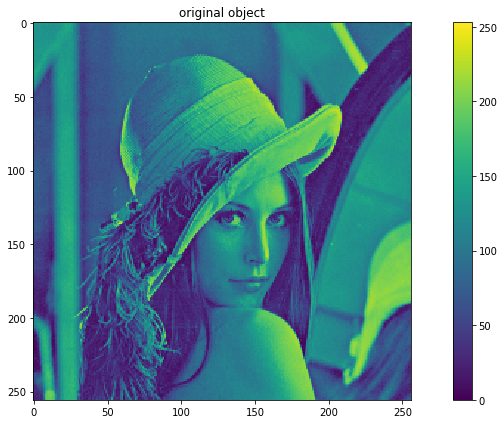

In [2]:
plot_image(image,"original object")

Next, we convolve $\mathbf{z}$ to $\mathbf{y}$. The PSF and noise can take pretty much any form, but here we use two simple prescriptions. We use a 2D Gaussian PSF with width $h$,

\begin{equation}
    w(r)=\frac{1}{2\pi h^2}\exp\left(-\frac{r^2}{2h^2}\right)\,,
\end{equation}

and noise,

\begin{equation}
    \sigma_{y_i}^2=(f_1\bar{y})^2+\left(f_2\sqrt{\frac{y_i}{\bar{y}}}\right)^2\,.
\end{equation}

Roughly speaking, $f_1$ defines the background noise as a fraction of the average intensity, and $f_2$ defines the local noise as a fraction of the square root of the intensity. To reiterate, the PSF and noise can take any form, but they need to be well defined/estimated in order to proceed with the analysis.

In [3]:
from maxent_image import psf_to_linear_map

# set width of PSF as a multiple of pixel width
sigma=3.

# set compact support radius
h_max=3

# make a grid of psf pixels
r_psf=2*np.ceil(sigma*h_max).astype(np.int)+1
x_min=-r_psf//2+1
x_max=r_psf//2+1
y_min=-r_psf//2+1
y_max=r_psf//2+1
x,y=np.meshgrid(np.arange(x_min,x_max),np.arange(y_min,y_max),indexing="ij")

# set Guassian PSF
r2=x**2+y**2
psf=np.where(r2<=(sigma*h_max)**2,np.exp(-r2/(2.*sigma**2)),0.)
psf/=np.sum(psf)

# make a linear map from PSF
A=psf_to_linear_map(psf,image.shape)

# apply PSF to z
y=A*z

# reshape y into an image
y=y.reshape((n_xpix,n_ypix))

# trim off the PSF edge effects
x_trim=np.ceil(sigma*h_max).astype(np.int)
y_trim=np.ceil(sigma*h_max).astype(np.int)
y=y[x_trim:-x_trim,y_trim:-y_trim]


# set noise level to a multiple of mean image intensity
# noise**2 = (noise_bg*y.mean())**2
#           +(noise_sn*sqrt(y/y.mean()))**2
f1=0.02
f2=0.02

# add noise to y
sigma_y=np.sqrt((f1*y.mean())**2+(f2*np.sqrt(y/y.mean()))**2)

y=np.random.normal(y,sigma_y)

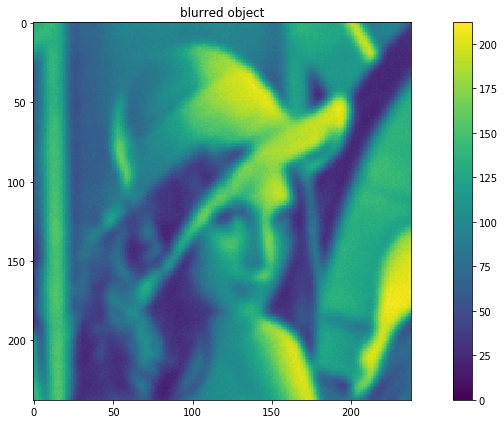

In [4]:
plot_image(y,"blurred object")

As you can see, we've generated a blurred, noisy image $\mathbf{y}$ from our imported image $\mathbf{z}$, via the linear map $\mathbf{A}$. We will use this same linear map in our analysis. We've also assumed that the noise values are uncorrelated, therefore $\mathbf{R}^{-1}$ is diagonal matrix with $R^{-1}_{ii}=1/\sigma_{y_i}^2$. A point to note is that $\mathbf{A}$ and $\mathbf{R}^{-1}$ are stored as sparse matrices, meaning that computational costs and storage requirements are fairly low.

## Loss-function minimisation

In order to find $\mathbf{x}$, we have to simultaneously solve two problems: i) minimise the loss function,

\begin{equation}
J(\mathbf{x})=-\alpha S(\mathbf{x})+\frac{\chi^2(\mathbf{x})}{2}\,,
\end{equation}

and ii) find a value for $\alpha$ such that $\chi^2\sim N\pm\sqrt{N}$ when $\nabla J(\mathbf{x})=0$, where$ N$ is size of the observation vector $\mathbf{y}$.

This can be achieved by arbitrarily selecting two values of $\alpha$ and performing iterations of the <a href="https://en.wikipedia.org/wiki/Secant_method">secant method</a> to solve $\chi^2-N=0$ to a tolerance of $\pm\sqrt{N}$. During each iteration, we use the <a href="https://en.wikipedia.org/wiki/Conjugate_gradient_method">conjugate gradient method</a> to solve $\nabla J(\mathbf{x})=0\,$.

Thankfully, scipy already has implementations of these methods. In order to maximise the efficiency of the algorithm, need to be able to calculate (but not necessarily store) the first and second partial derivatives of $J(\mathbf{x})$:

\begin{align}
    \nabla J(\mathbf{x})&=-\alpha\nabla S(\mathbf{x})+\mathbf{A}^\mathrm{T}\mathbf{R}^{-1}(\mathbf{A}\mathbf{x}-\mathbf{y})\,;\\
    \mathbf{H}J(\mathbf{x})&=-\alpha\,\mathbf{H}S(\mathbf{x})+\mathbf{A}^\mathrm{T}\mathbf{R}^{-1}\mathbf{A}\,.
\end{align}

Thankfully, we don't have to compute the entire Hessian! We only have to provide a function which supplies $\mathbf{H}J(\mathbf{x})\,\mathbf{p}$, the product of the Hessian and an arbitrary vector $\mathbf{p}$. The entropy gradient $\nabla S(\mathbf{x})$ and Hessian matrix $\mathbf{H}S(\mathbf{x})$ have pretty ugly analytical forms which we'll list and the end of this notebook.

In [5]:
# estimate model image using observed image, noise map and PSF
from maxent_image import estimator

M=estimator(y,sigma_y,psf)


solving for x

iteration: 1
log alpha: 16.838106880261343
log chi^2_nu: 2.4784790628686473
time taken (s): 7.653213739395142

iteration: 2
log alpha: 15.838106880261343
log chi^2_nu: 1.2248280061766348
time taken (s): 9.790022134780884

iteration: 3
log alpha: 14.861098166681533
log chi^2_nu: 0.34398686439720727
time taken (s): 18.413976192474365

iteration: 4
log alpha: 14.542490757969857
log chi^2_nu: 0.17107345498545357
time taken (s): 13.409814596176147

iteration: 5
log alpha: 14.22727361906956
log chi^2_nu: 0.04857118454166809
time taken (s): 15.277695417404175

iteration: 6
log alpha: 14.102292508362321
log chi^2_nu: 0.011047800397962604
time taken (s): 14.506021976470947

iteration: 7
log alpha: 14.065495018047448
log chi^2_nu: 0.0010277393178341754
time taken (s): 14.771409749984741


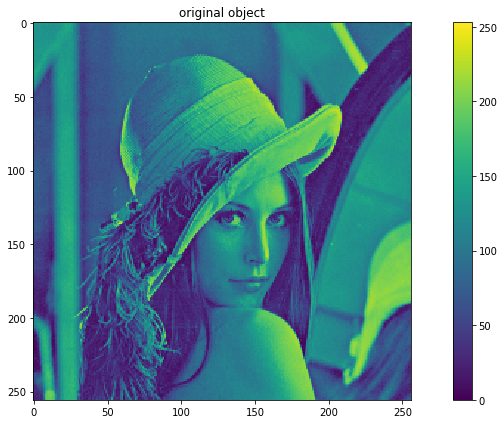

In [6]:
plot_image(image,"original object")

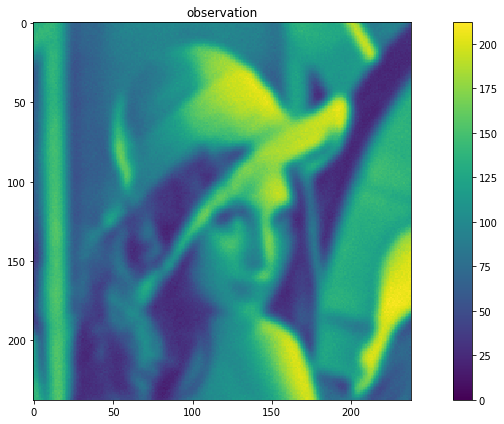

In [7]:
plot_image(y,"observation")

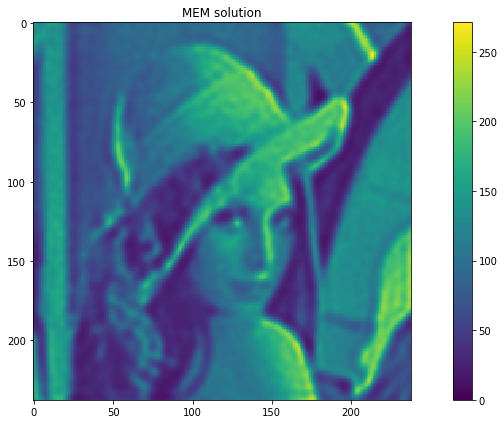

In [8]:
plot_image(M.x_image(),"MEM solution")

Essentially, the $\mathbf{x}$ is the model solution with the maximum possible entropy, given the constraint $\chi^2\sim N\pm\sqrt{N}$. Hopefully you can see that $\mathbf{x}$ has roughly double resolution of $\mathbf{y}$, although the noise appears to cause some ringing on the scale of the PSF.

We can reduce this noise by relaxing the fit a little. If we examine the the plot of $\log\chi^2_0$ (the value of $\chi^2$ when $J(\mathbf{x})=0$) as a function of $\log\alpha$, we find two regimes separated by a "kink". To the left of this kink, $J(\mathbf{x})$ is dominated by the data, and $\log\chi^2_0$ vs $\log\alpha$ is roughly flat. To the right, $\log\chi^2_0$ increases linearly with $\log\alpha$, as the fit is diluted by entropy. The location of this kink (plot shown below) represents an ideal compromise between fitting the data and maximising the entropy. Indeed, if the noise map is over or underestimated, this method is vital in finding the correct fit. To locate the kink, we must find the maximum of the curvature of the line, i.e.

\begin{equation}
\kappa=\frac{\left|\frac{\partial^2\log\chi^2_0}{\partial\log\alpha^2}\right|}{\left(1+\frac{\partial\log\chi^2_0}{\partial\log\alpha}\right)^\frac{3}{2}}\,.
\end{equation}

Here, we use finite differences to calculate the first and second derivatives of the line. The maximum is found using Brent's method. This isn't necessarily the fastest method (about three times slower than the last one), but it gets the job done!

In [9]:
M.relax_fit()


relaxing fit

iteration: 1
log alpha: 14.065495018047448
log chi^2_nu: 0.0010277378262770753
curvature: 0.29085517335641226
time taken (s): 35.47773885726929

iteration: 2
log alpha: 14.542490757969857
log chi^2_nu: 0.17107346555506986
curvature: 0.3663068203570235
time taken (s): 36.38900327682495

iteration: 3
log alpha: 15.314286083019471
log chi^2_nu: 0.6886524585785114
curvature: 0.2322396211324955
time taken (s): 25.184295892715454

iteration: 4
log alpha: 14.837290331097758
log chi^2_nu: 0.3291575818846777
curvature: 0.3476634196699562
time taken (s): 32.59718990325928

iteration: 5
log alpha: 14.360294603174655
log chi^2_nu: 0.09503030857324823
curvature: 0.3493931226230622
time taken (s): 54.30541801452637

iteration: 6
log alpha: 14.593251150697634
log chi^2_nu: 0.19506147450170808
curvature: 0.3671503087779773
time taken (s): 55.54257392883301

iteration: 7
log alpha: 14.603629148815168
log chi^2_nu: 0.2001244951792902
curvature: 0.36720537122146213
time taken (s): 42.05762

Text(0, 0.5, 'log chi^2 curvature')

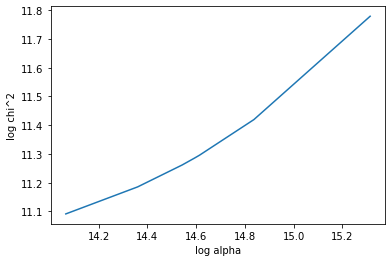

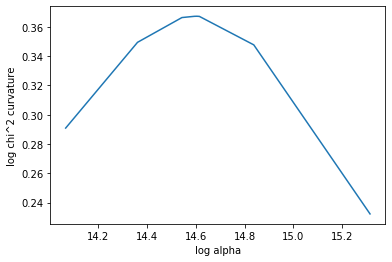

In [10]:
# plot chi^2_0 vs alpha
fig,ax=plt.subplots(1,1)
ax.plot(M.log_alpha,M.log_chi2)
ax.set_xlabel("log alpha")
ax.set_ylabel("log chi^2")

# plot curvature vs alpha
fig,ax=plt.subplots(1,1)
ax.plot(M.log_alpha,M.kappa)
ax.set_xlabel("log alpha")
ax.set_ylabel("log chi^2 curvature")

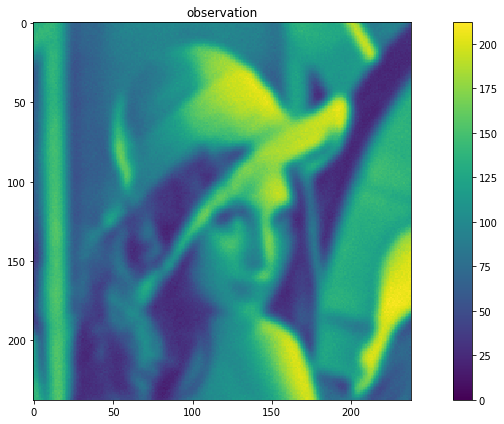

In [11]:
plot_image(y,"observation")

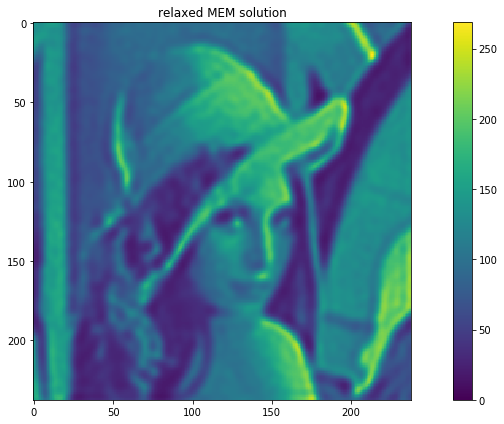

In [12]:
plot_image(M.x_image(),"relaxed MEM solution")

## Uncertainties

Finally, as scientists, these analyses aren't much use to us without uncertainty maps. Thankfully we've nearly calculated them already. The covariance matrix of $\mathbf{x}$ is related to the loss function:

\begin{equation}
    \Sigma(\mathbf{x})=2[\mathbf{H}J(\mathbf{x})]^{-1}\,.
\end{equation}

While the full Hessian and its inverse are prohibitively expensive to calculate, we only need the diagonal elements to estimate the variances for each value of $\mathbf{x}$.

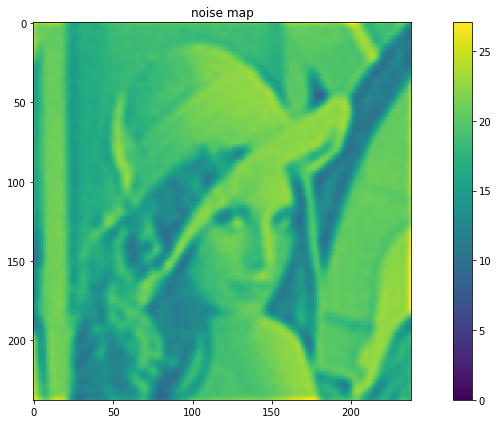

In [13]:
plot_image(M.sigma_x_image(),"noise map")

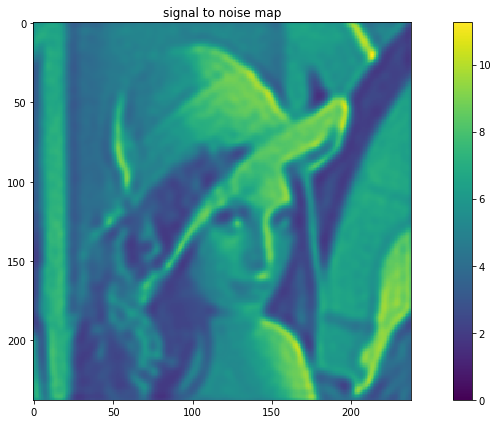

In [14]:
plot_image(M.x_image()/M.sigma_x_image(),"signal to noise map")

It's worth noting that the signal to noise is probably a little lower than what you're comfortable with. This is because the pixel values of $\mathbf{x}$ are locally anti-correlated thanks to the PSF. They can effectively "jiggle about" within the PSF, so long as their combined value adds up to that of $\mathbf{y}$. Whether you're happy with this, or want to reduce the noise by sub-sampling the image is up to you.

## Entropy first and second partial derivatives

Thanks to a bit of mucking around on <a href="https://www.wolframalpha.com/">Wolfram</a>, we find that the elements of the entropy gradient $\nabla S(\mathbf{x})$ vector are given by

\begin{align}
    \frac{\partial S}{\partial x_i}=&\frac{F-x_i\ln(f_i) - \left(X - x_i \right)\ln(f_i)}{X^2}\,;\\
    f_i=&\frac{x_i}{X}\,;\\
    X=&\sum\limits_j x_j\,;\\
    F=&\sum\limits_j x_j\ln(f_j)\,.
\end{align}

Members of the entropy Hessian $\mathbf{H}S(\mathbf{x})$ matrix are given by

\begin{align}
    \frac{\partial^2 S}{\partial x_i^2}=&\frac{X^2-x_i^2-x_iX +2x_i(F-x_i\ln(f_i))-2x_i(X-x_i)\ln(f_i)}{x_iX^3}\,;\\
    \frac{\partial^2 S}{\partial x_i \partial x_{j\neq i}}=&\frac{X+(X-2x_i)\ln(f_i)-2(F-x_i\ln(f_i)-x_j\ln(f_j))+(X-2x_j)\ln(f_j)}{X^3}\,.
\end{align}

Note: these are correct to the best of my knowledge, but I have been wrong before! Let me know if you find any errors!
